In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridSpec

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import gym
from gym import spaces

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from collections import deque
import random

%matplotlib inline

In [2]:
pd.options.display.max_columns = 40

In [3]:
data_path = "../data/Customer-Churn-Records.csv"
data = pd.read_csv(data_path)
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


# 1. Data Preprocessing

In [4]:
data.drop(['RowNumber', 'Surname', 'CustomerId'], axis = 1, inplace = True)

In [5]:
def resumetable(df):    
    print(f'data shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns = ['data type'])
    summary = summary.rename(columns = {'index': 'feature'})
    summary['num_NaN'] = df.isnull().sum().values
    summary['num_unique'] = df.nunique().values
    summary['data category'] = None
    for col in df.columns:
        if col == 'Exited':
            summary.loc[col, 'data category'] = 'Binary'
        elif df[col].dtype == object:
            summary.loc[col, 'data category'] = 'Categorical'
        elif df[col].dtype == float:
            summary.loc[col, 'data category'] = 'Numeric'
        elif df[col].dtype == int:
            summary.loc[col, 'data category'] = 'Integer'

    
    return summary

In [6]:
summary = resumetable(data)
summary

data shape: (10000, 15)


,data type,num_NaN,num_unique,data category
CreditScore,int64,0,460,Integer
Geography,object,0,3,Categorical
Gender,object,0,2,Categorical
Age,int64,0,70,Integer
Tenure,int64,0,11,Integer
Balance,float64,0,6382,Numeric
NumOfProducts,int64,0,4,Integer
HasCrCard,int64,0,2,Integer
IsActiveMember,int64,0,2,Integer
EstimatedSalary,float64,0,9999,Numeric


We can conclude that this dataset does not include any missing values. Additionally, we identified some categorical variables (Geography, Gender, Card Type). We also need to simplify the column names for easier recognition

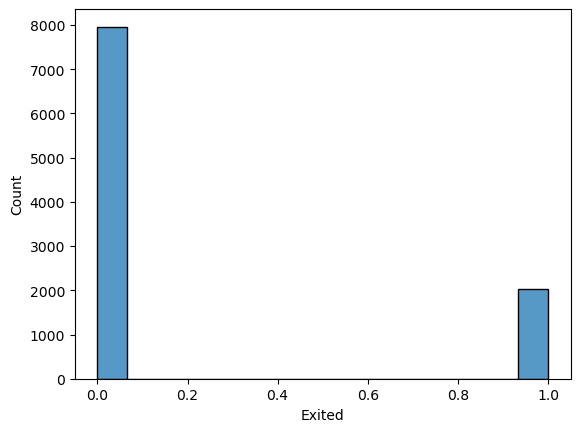

In [7]:
sns.histplot(data['Exited']);

Here, the plot suggests that the target variable is in an inbalance status, so we should focus more on the small proportion of target value 1. 

In [10]:
zero = data[data['Balance'] == 0]

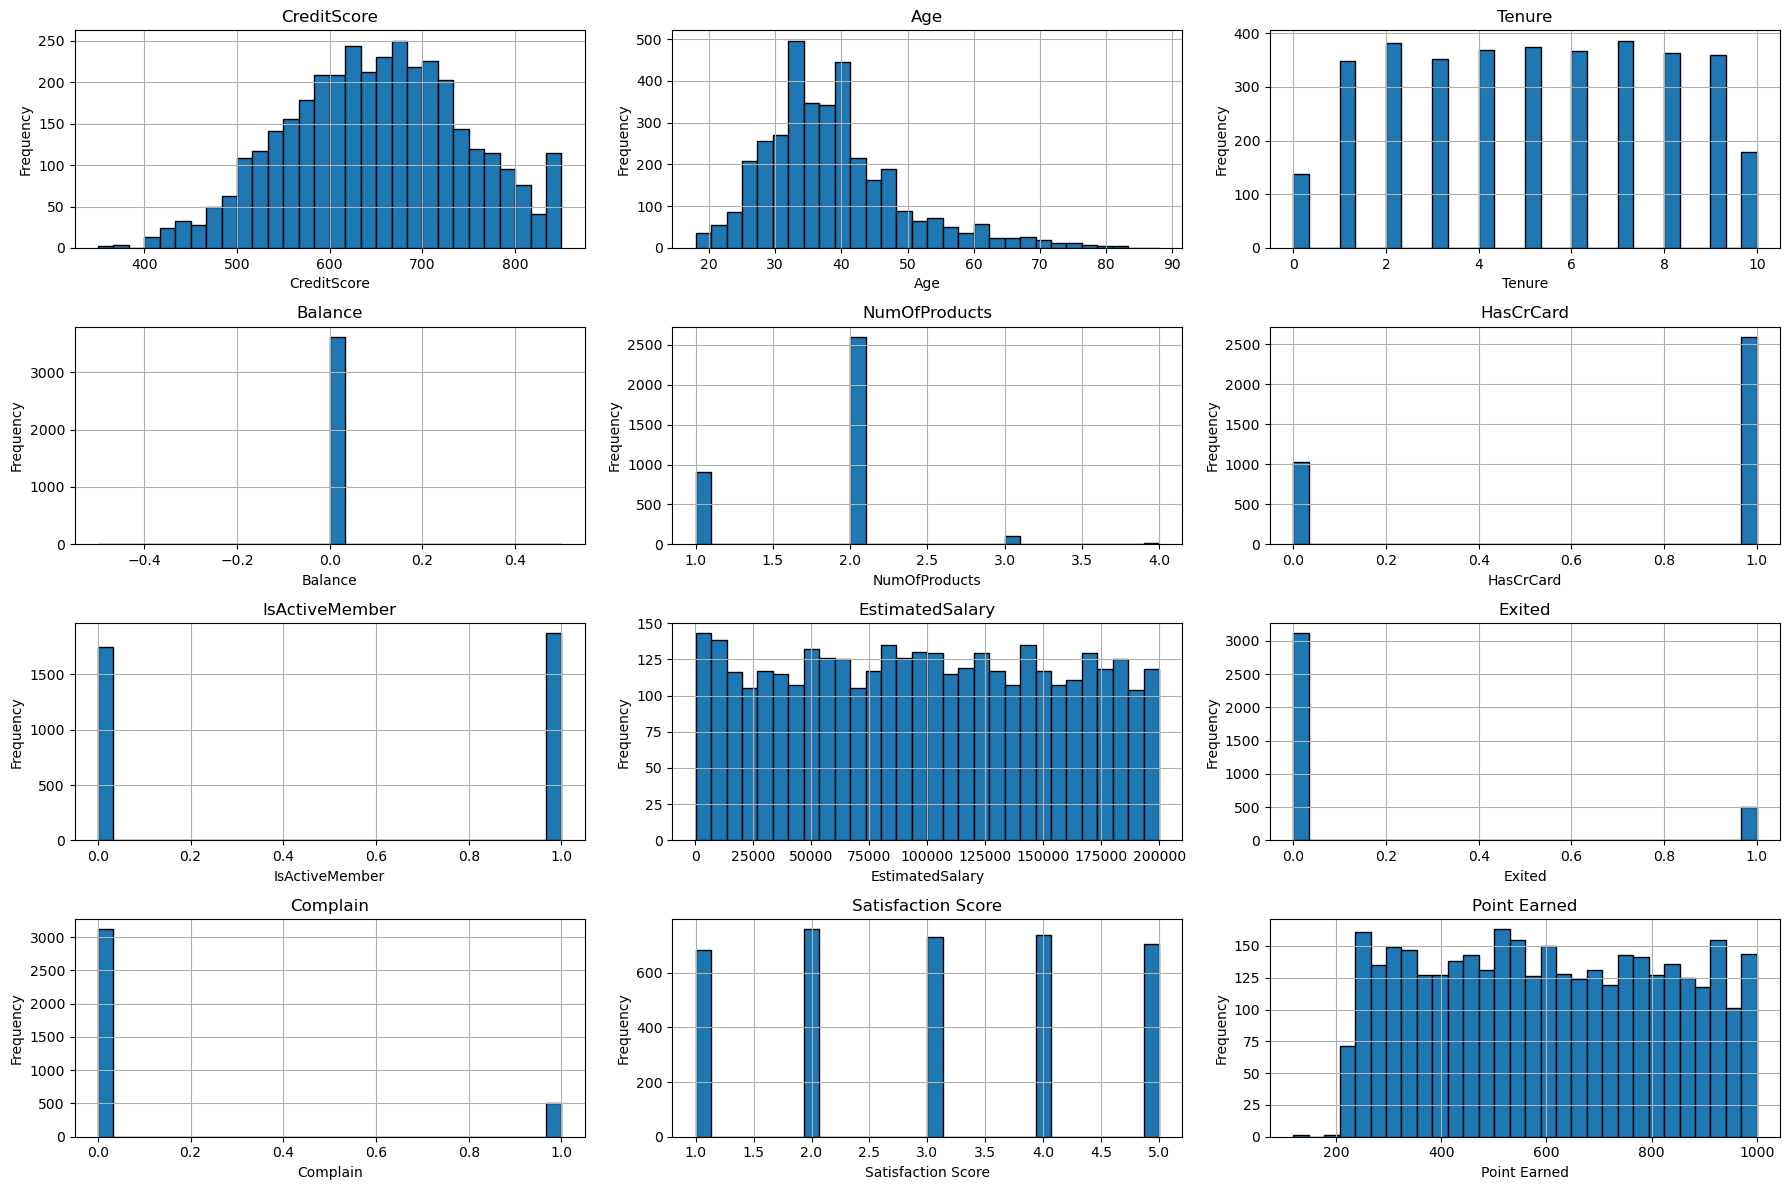

In [11]:
numeric_columns = zero.select_dtypes(include=['float64', 'int64']).columns

# Re-plot using subplots with a larger figure to avoid scrolling
plt.figure(figsize=(18, 12))  # Larger figure to fit all plots
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)  # Adjust grid size to fit all features
    zero[column].hist(bins=30, edgecolor='black')
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [12]:
round(data.describe(), 2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0,10000.0,10000.00,10000.00
mean,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.2,0.2,3.01,606.52
std,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.4,0.4,1.41,225.92
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.0,0.0,1.00,119.00
25%,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.0,0.0,2.00,410.00
50%,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.92,0.0,0.0,3.00,605.00
75%,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.0,0.0,4.00,801.00
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0,1.0,5.00,1000.00


We have a binary outcome here: 1 indicates that the customer left the bank, while 0 means the customer did not. The results suggest that the number of customers who left the bank is four times greater than the number of customers who did not churn based on this dataset.

### One-hot encoding (categorical data)

In [13]:
data = pd.get_dummies(data, columns=['Geography', 'Gender', 'Card Type'])

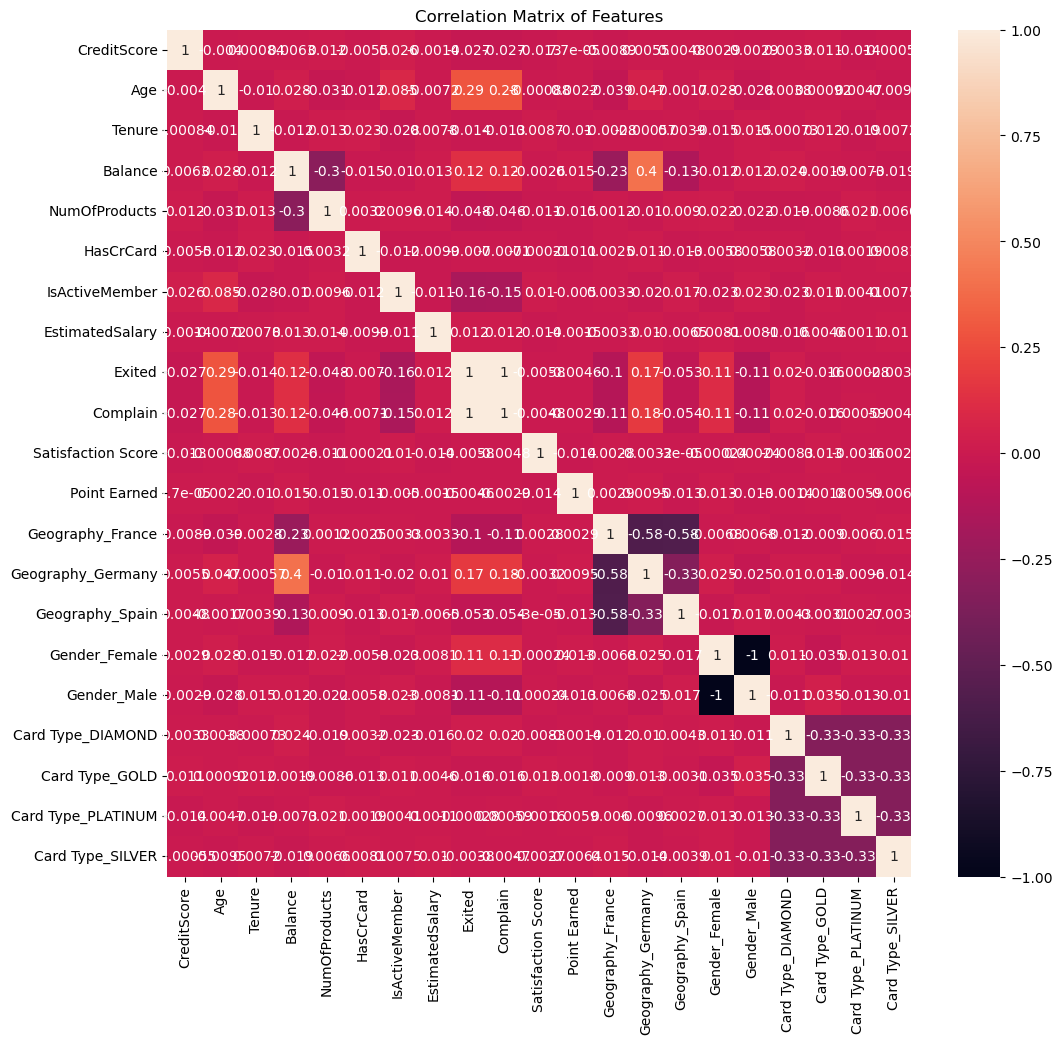

In [14]:
corr_matrix = data.corr()

plt.figure(figsize=(12, 11))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix of Features')
plt.show()

In [15]:
# data.drop(['Complain'], axis = 1, inplace = True) 보류 

### Data Scaling

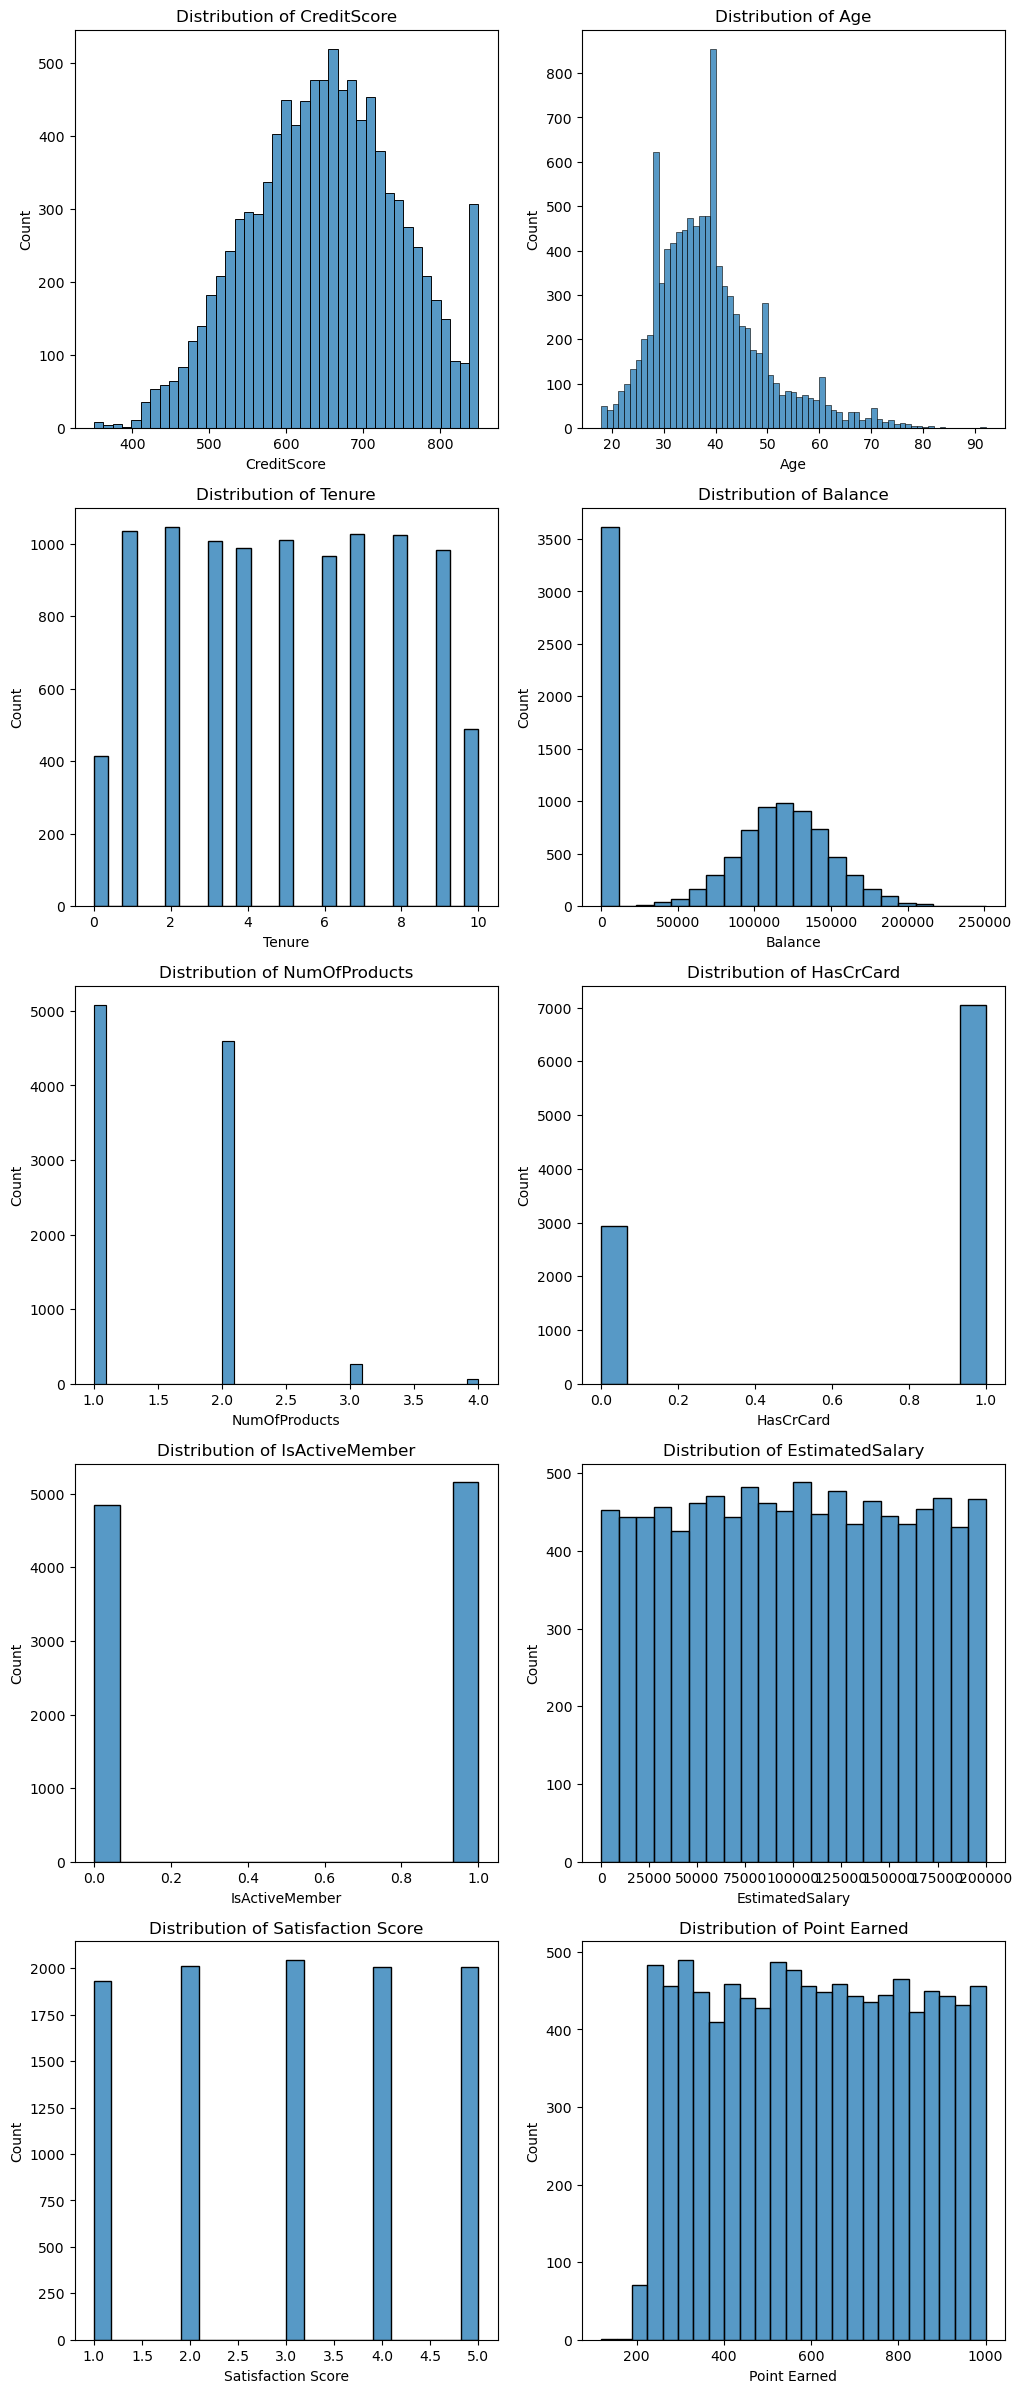

In [16]:
numeric_columns = summary[summary['data category'].isin(['Numeric', 'Integer'])].index.tolist()

if "Complain" in numeric_columns:
     numeric_columns.remove("Complain")

fig, axes = plt.subplots(len(numeric_columns) // 2 + len(numeric_columns) % 2, 2, figsize=(12, 30))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(data[col],ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

### 우선 스케일링또한 보류

- numofproducts 변수는 1, 2, 3, 4 등의 숫자간에 discrete 성격을 보여주기때문에 범주형 변수로 간주한다.
satisfaction score 변수도 명확한 범주를 보여줌. (1, 2, 3, 4, 5) 
이 두 변수는 원-핫 인코딩을 진행

- Balance 변수를 보면 0에 많은 데이터가 몰려있는 걸 알 수 있다. 이는 모델이 잔액 0 여부를 구분하도록 하기 위해 이진 변수로 추가

- CreditScore: Standard Scaling 

- Age: Standard Scaling 
    WHY? Age는 정규 분포에 가깝고 나이 간의 상대적 차이를 유지하는게 중요해보임. 그리고 30~40대에 몰려있는게 가장 큰 이유

- EstimatedSalary: Min-Max Scaling 
    WHY? 분포가 다른 피처들 중 가장 균등함
  
- Point Earned: Robust Scaling 
    WHY? Point Earned는 최소값 근처에 데이터가 적고 나머지 값들은 균등하게 분포되어 있어 이상치의 영향을 줄이기 위해 Robust Scaling 사용

- Balance: Robust Scaling 
    WHY? Balance는 0에 많은 데이터가 몰려 있어서 중앙값과 IQR을 기준으로 스케일링하여 이상치의 영향을 줄이기


In [17]:
data = pd.get_dummies(data, columns=['NumOfProducts', 'Satisfaction Score'])

In [18]:
# standard_scaler = StandardScaler()
# min_max_scaler = MinMaxScaler()
# robust_scaler = RobustScaler()

# data[['CreditScore', 'Age']] = standard_scaler.fit_transform(data[['CreditScore', 'Age']])
# data['EstimatedSalary'] = min_max_scaler.fit_transform(data[['EstimatedSalary']])
# data[['Point Earned', 'Balance']] = robust_scaler.fit_transform(data[['Point Earned', 'Balance']])

In [19]:
data.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Satisfaction Score_1,Satisfaction Score_2,Satisfaction Score_3,Satisfaction Score_4,Satisfaction Score_5
0,619,42,2,0.00,1,1,101348.88,1,1,464,True,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False
1,608,41,1,83807.86,0,1,112542.58,0,1,456,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False
2,502,42,8,159660.80,1,0,113931.57,1,1,377,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False
3,699,39,1,0.00,0,0,93826.63,0,0,350,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True
4,850,43,2,125510.82,1,1,79084.10,0,0,425,False,False,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True


### Feature Engineering

In [20]:
# data['Zero_Balance'] = (data['Balance'] == 0).astype(int)

In [21]:
data.head()

,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Satisfaction Score_1,Satisfaction Score_2,Satisfaction Score_3,Satisfaction Score_4,Satisfaction Score_5
0,619,42,2,0.00,1,1,101348.88,1,1,464,True,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False
1,608,41,1,83807.86,0,1,112542.58,0,1,456,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False
2,502,42,8,159660.80,1,0,113931.57,1,1,377,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False
3,699,39,1,0.00,0,0,93826.63,0,0,350,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True
4,850,43,2,125510.82,1,1,79084.10,0,0,425,False,False,True,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True


In [22]:
# bins = [0, 2, 4, 6, 8, 10]
# labels = ['0-2', '3-4', '5-6', '7-8', '9-10']
# data['Tenure_bin'] = pd.cut(data['Tenure'], bins = bins, labels = labels, include_lowest = True)
# data = pd.get_dummies(data, columns = ['Tenure_bin'], prefix = 'tenure')

### Feature importance by random forest

In [23]:
X = data.drop('Exited', axis=1)
y = data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

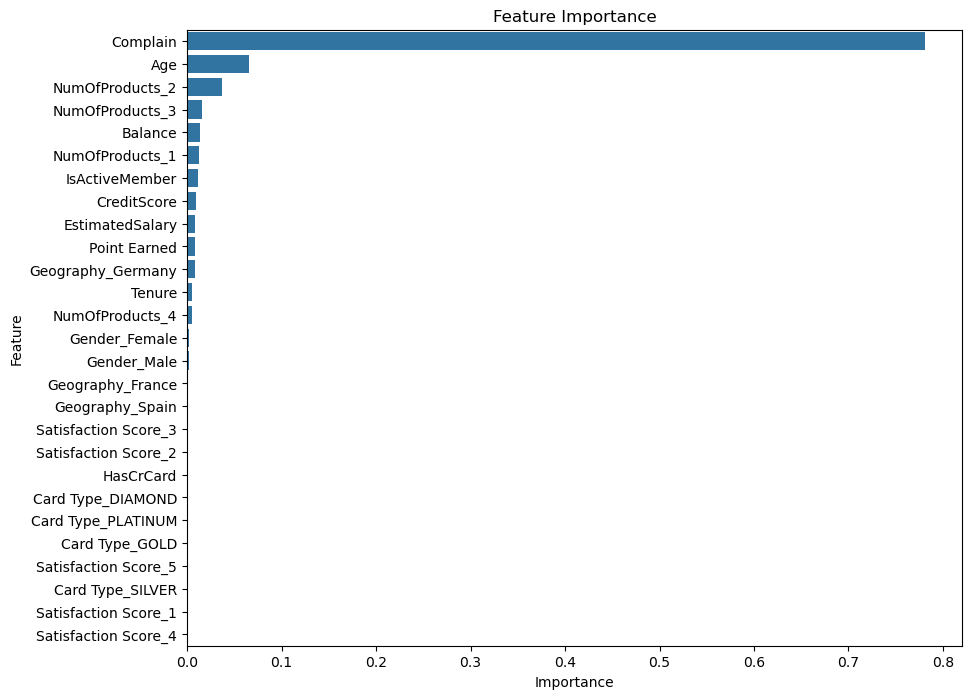

In [24]:
plt.figure(figsize=(10, 8))
sns.barplot(feature_importance_df, x = 'Importance', y = 'Feature')
plt.title('Feature Importance')
plt.show();

# 2. Exploratory Data Analysis

Correlation between Age and Exited: 0.285


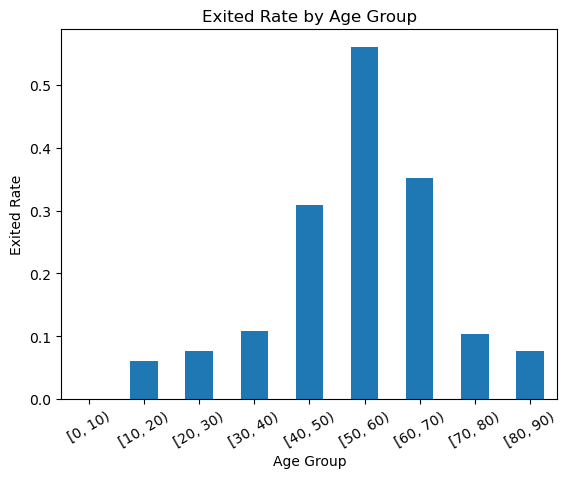

In [99]:
# Age vs Exited

age_groups = pd.cut(data['Age'], bins=range(0, 100, 10), right=False)
age_exit_ratio = data.groupby(age_groups, observed=False)['Exited'].mean()

age_exit_ratio.plot(kind = 'bar')
plt.xlabel('Age Group')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Age Group')
plt.xticks(rotation = 30);

correlation = data[['Age', 'Exited']].corr().iloc[0, 1]
print(f"Correlation between Age and Exited: {correlation:.3f}")

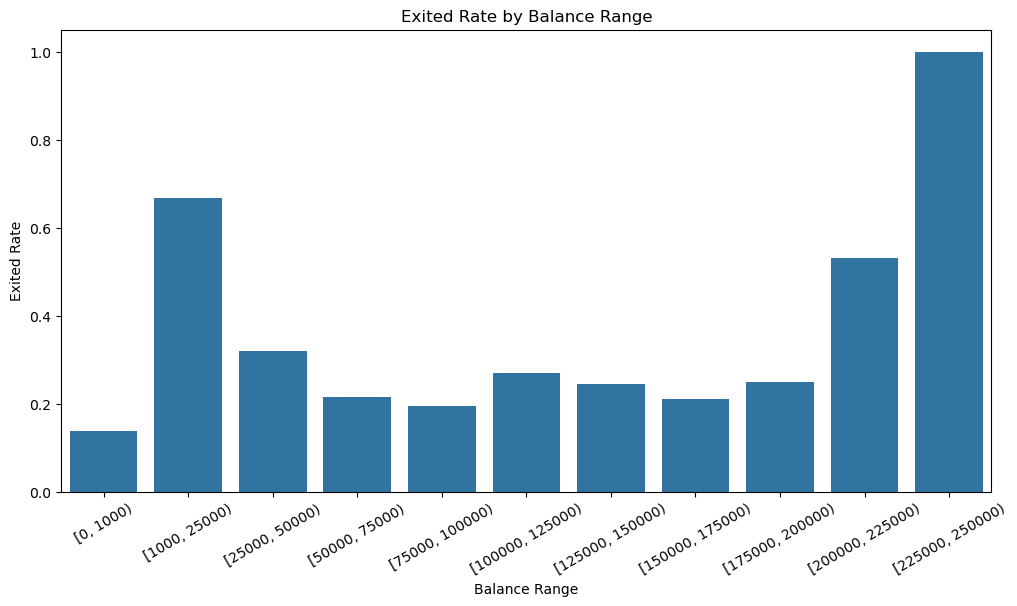

In [97]:
# Balance Range vs Exited

balance_bins = pd.cut(data['Balance'], bins=[0, 1000, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 225000, 250000], right=False)
balance_exit_ratio = data.groupby(balance_bins, observed=False)['Exited'].mean()

plt.figure(figsize = (12, 6))
sns.barplot(data = balance_exit_ratio)
plt.xlabel('Balance Range')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Balance Range')
plt.xticks(rotation=30);

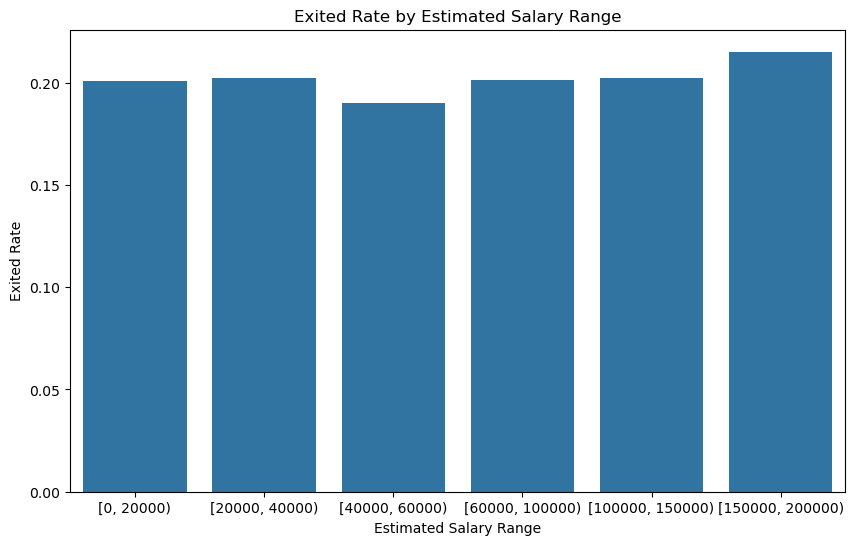

In [96]:
# Estimated Salary VS Exited
salary_bins = pd.cut(data['EstimatedSalary'], bins=[0, 20000, 40000, 60000, 100000, 150000, 200000], right=False)
salary_exit_ratio = data.groupby(salary_bins, observed=False)['Exited'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(data = salary_exit_ratio)
plt.xlabel('Estimated Salary Range')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Estimated Salary Range')
plt.xticks(rotation=0);

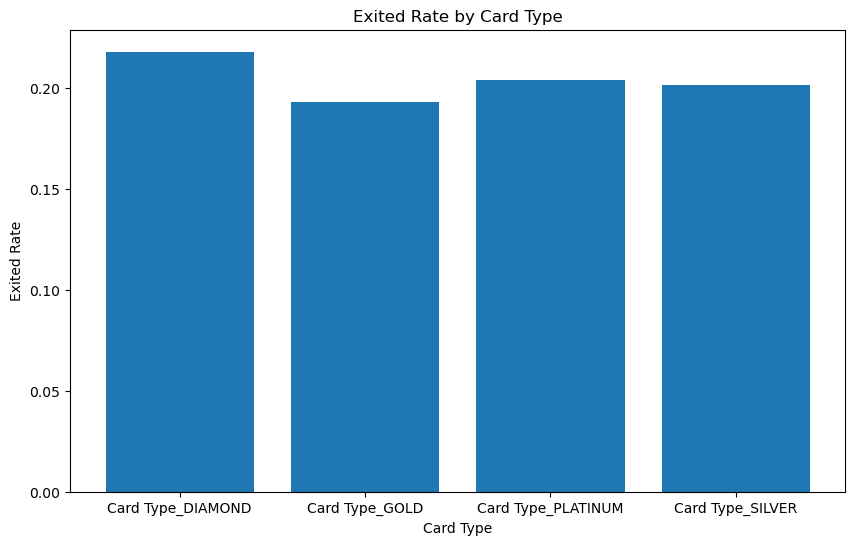

In [80]:
# Card Type VS Exited

card_types = ['Card Type_DIAMOND', 'Card Type_GOLD', 'Card Type_PLATINUM', 'Card Type_SILVER']
card_exit_ratios = {}

for card_type in card_types:
    card_exit_ratios[card_type] = data.loc[data[card_type] == 1, 'Exited'].mean()

card_exit_df = pd.DataFrame(list(card_exit_ratios.items()), columns=['Card Type', 'Exited Rate'])

plt.figure(figsize = (10, 6))
plt.bar(card_exit_df['Card Type'], card_exit_df['Exited Rate'])
plt.xlabel('Card Type')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Card Type')
plt.xticks(rotation=0);

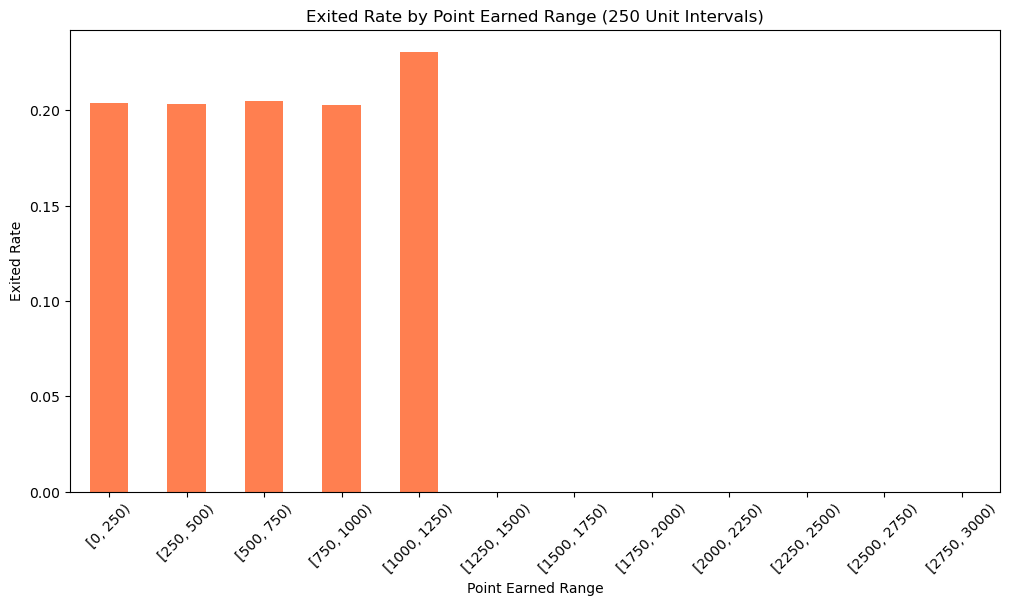

In [86]:
point_bins = pd.cut(data['Point Earned'], bins=range(0, 3001, 250), right=False)

# Calculate Exited rate for each bin, with observed=False to suppress the warning
point_exit_ratio = data.groupby(point_bins, observed=False)['Exited'].mean()

# Plotting the exit rate by Point Earned range
plt.figure(figsize=(12, 6))
point_exit_ratio.plot(kind='bar', color='coral')
plt.xlabel('Point Earned Range')
plt.ylabel('Exited Rate')
plt.title('Exited Rate by Point Earned Range (250 Unit Intervals)')
plt.xticks(rotation=45)
plt.show()

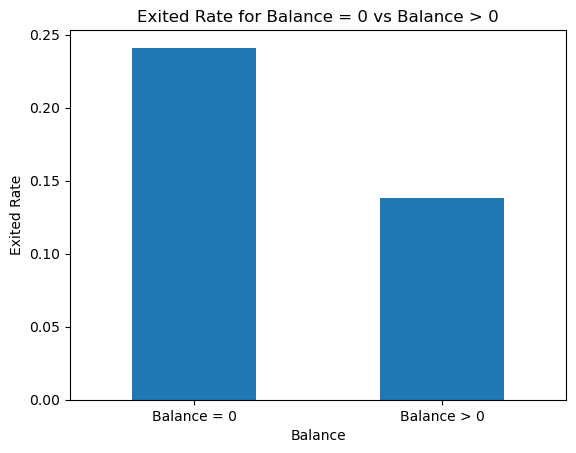

Balance
False    0.240953
True     0.138236
Name: Exited, dtype: float64


In [111]:
balance_exit_rate = data.groupby(data['Balance'] == 0)['Exited'].mean()

balance_exit_rate.plot(kind='bar')
plt.xticks([0, 1], ['Balance = 0', 'Balance > 0'], rotation=0)
plt.ylabel('Exited Rate')
plt.title('Exited Rate for Balance = 0 vs Balance > 0')
plt.show()

print(balance_exit_rate)

# 3. Reinforcement Learning Environment Setup

In [25]:
class ChurnEnvironment(gym.Env):
    def __init__(self, data):
        super(ChurnEnvironment, self).__init__()
        self.data = data.reset_index(drop=True)
        self.current_step = 0
        
        self.state_features = [
            'CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard',
            'IsActiveMember', 'EstimatedSalary', 'Complain', 'Point Earned',
            'Geography_1', 'Geography_2', 'Geography_3', 'Gender_Female',
            'Gender_Male', 'Card Type_DIAMOND', 'Card Type_GOLD',
            'Card Type_PLATINUM', 'Card Type_SILVER', 'NumOfProducts_1',
            'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4',
            'Satisfaction Score_1', 'Satisfaction Score_2', 'Satisfaction Score_3',
            'Satisfaction Score_4', 'Satisfaction Score_5']
        
        # Define state space as a continuous vector
        self.state_space = spaces.Box(low=0, 
                                      high=np.inf, 
                                      shape=(len(self.state_features),), 
                                      dtype=np.float32)
        

        self.action_space = spaces.Discrete(4)
        self.actions = {
            0: "Personalized Interest Rate Adjustment",
            1: "Bonus Point Multiplier",
            2: "Customized Product Bundling",
            3: "Age-based Promotion"}
        
    def reset(self):
        """
        Select random customer data as initial state at the start of each episode
        """
        self.current_step = np.random.randint(0, len(self.data))
        return self._get_state()
    
    def _get_state(self):
        """
        Return the current state vector
        """
        state = self.data.loc[self.current_step, self.state_features].values
        return state.astype(np.float32)

    def calculate_reward(self, customer, action):
        reward = 0
        
        # 1. Personalized Interest Rate Adjustment
        if action == 0:
            if customer['CreditScore'] >= 750 and customer['Balance'] >= 150000:
                reward += 1.0
            elif customer['CreditScore'] >= 700 or customer['Balance'] >= 100000:
                reward += 0.7
            elif customer['CreditScore'] >= 650 or customer['Balance'] >= 50000:
                reward += 0.3

        # 2. Bonus Point Multiplier
        elif action == 1:
            if customer['Point Earned'] < 300:
                reward += 0.3
            elif 300 <= customer['Point Earned'] < 500:
                reward += 0.5
            elif 500 <= customer['Point Earned'] < 800:
                reward += 1.0
            else:
                reward += 1.5
            if customer['IsActiveMember'] == 0:
                reward += 0.5

        # 3. Financial Planning Assistance
        elif action == 4:
            if customer['Balance'] >= 200000:
                reward += 1.2  # Highest churn rate in Balance over 200,000
            elif 100000 <= customer['Balance'] < 150000:
                reward += 0.8  
            elif 50000 <= customer['Balance'] < 100000:
                reward += 0.5  
            else:
                reward += 0.3  

        # 4. Age-based Promotion
        elif action == 6:
            if customer['Age'] < 40:
                reward += 0.5  
            elif 40 <= customer['Age'] < 50:
                reward += 1.0  
            elif 50 <= customer['Age'] < 60:
                reward += 2.0  # Highest churn rate age group
            elif 60 <= customer['Age'] < 70:
                reward += 1.2
            else:
                reward += 0.5

        if customer['Exited'] == 0:
            reward += 1.0  # Reward if customer is retained
        else:
            reward -= 1.0  # Penalty if customer has exited
        return reward

    def step(self, action):
        customer = self.data.iloc[self.current_step]
        reward = self.calculate_reward(customer, action) 
        self.current_step += 1
        done = self.current_step >= len(self.data)
        next_state = self._get_state() if not done else np.zeros(self.state_space.shape)
        return next_state, reward, done, {}